In [1]:
import glob, pandas, uproot, matplotlib, re, math
import numpy as np
from gap_statistic import OptimalK
from plotParams import varLabels, binnings, units
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

randomState = 5
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
font = {'size':14}
matplotlib.rc('font', **font)

In [17]:
path='/data/atlasfs02/a/users/whopkins/ccMET/'
rTag = 'r9364*'
# Need to add year weight somehow and need to make sure to concetenate signals
#rTag = ''
paths = glob.glob(path+f'*{rTag}.root')
sigPaths = [path for path in paths if 'TT_mixedTC' in path]
bkgPaths = [path for path in paths if 'TT_mixedTC' not in path and 'mc16_13TeV.364' not in path and 'Sherpa_221_' not in path and 'mc16' in path]
treeName='Nominal'

# Only select variables that were used in the original signal regions.
from ccMET_selections import selections
srList = ['SRA']
splitPat = '[><=]'
allCuts = []
for sr in srList:
    allCuts.extend([re.split(splitPat, cut.replace('(', '').replace(')', ''))[0].rstrip().lstrip() for cut in selections[sr].split("*")])
branches = sorted(list(set(allCuts)))
branches.append('pT_2jet')
branches.append('pT_1cjet')
branches.append('pT_2cjet')
branches.append('RunNumber')
branches.append('LumiWeight')
branches.append('AnalysisWeight')

#print(branches) 
allSampLabels = []
for path in sigPaths:
    fName = path.split('/')[-1]
    
    firstSplitStr = 'mixedTC_';
    secondSplitStr = '.'
    allSampLabels.append('sig_'+fName.split(firstSplitStr)[1].split(secondSplitStr)[0].replace('_MET100', ''))

dataList = []
lumi = 139000
# This is needed due to memory constraints, I think...
nSigEvents = 1000
sigData = {}
nSigs = 80
chosenPaths = sigPaths#[:nSigs]
minNEvents = 100
sampLabels = []
for path, sampName in zip(sigPaths, allSampLabels):
    #if '27_' in sampName or '77_' in sampName or '62_' in sampName or '12_' in sampName:
    #    continue
    stopMass, lspMass = [int(mass) for mass in sampName.split('_')[1:3]]
    tree = uproot.open(path)[treeName]
    data = tree.arrays(branches, library='pd')
    if 'pT_1jet' not in sorted(tree.keys()):
        continue
    data['weight'] = data['AnalysisWeight']*data['LumiWeight']*lumi*4
    if data.shape[0] < minNEvents or data.weight.sum() < 1E-4:
        print(sampName, 'had few events.')
        continue
    data['sampName'] = sampName
    sigData[sampName] = data
    # if data.shape[0] < nSigEvents:
    #     sigData[sampName] = data
    # else:
    #     sigData[sampName] = data.sample(n=nSigEvents)
    sampLabels.append(sampName)

bkgData = []
weights = []
for path in bkgPaths:
    fName = path.split('/')[-1]
    sampName = fName.split('.')[2]
    inF = uproot.open(path)
    tree = inF[treeName]
    if 'pT_1jet' not in sorted(tree.keys()):
        continue
    data = tree.arrays(branches, library='pd')
    data['weight'] = data['AnalysisWeight']*data['LumiWeight']*lumi
    data['sampName'] = 'bkg'
    bkgData.append(data)
dataList = list(sigData.values())
#dataList.extend(bkgData)

allSamps = pandas.concat(dataList)
sampLabels.append('bkg')
print(sorted(sampLabels))

['bkg', 'sig_1000_1', 'sig_1000_100', 'sig_1000_200', 'sig_1000_300', 'sig_1000_400', 'sig_1000_500', 'sig_1000_600', 'sig_1000_700', 'sig_1050_150', 'sig_1050_250', 'sig_1050_50', 'sig_1100_1', 'sig_1100_100', 'sig_1100_200', 'sig_1100_300', 'sig_1100_400', 'sig_1100_500', 'sig_1100_600', 'sig_1100_700', 'sig_1200_1', 'sig_1200_100', 'sig_1200_200', 'sig_1200_300', 'sig_1200_400', 'sig_1200_500', 'sig_1200_600', 'sig_1300_1', 'sig_1300_100', 'sig_1300_200', 'sig_1300_300', 'sig_1300_400', 'sig_1300_500', 'sig_400_225', 'sig_500_1', 'sig_500_325', 'sig_550_375', 'sig_600_1', 'sig_600_300', 'sig_600_425', 'sig_650_350', 'sig_650_475', 'sig_700_1', 'sig_700_100', 'sig_700_200', 'sig_700_300', 'sig_700_400', 'sig_700_525', 'sig_750_250', 'sig_750_350', 'sig_750_450', 'sig_750_575', 'sig_800_1', 'sig_800_100', 'sig_800_200', 'sig_800_300', 'sig_800_400', 'sig_800_500', 'sig_800_625', 'sig_850_150', 'sig_850_250', 'sig_850_350', 'sig_850_450', 'sig_850_50', 'sig_900_1', 'sig_900_100', 'sig_

In [18]:
print('\n'.join(sorted([path.split('/')[-1] for path in bkgPaths])))

mc16_13TeV.345935.PhPy8EG_A14_ttbarMET100_200_hdamp258p75_nonallhad.deriv.DAOD_PHYS.e6620_s3126_r9364_p4355.root
mc16_13TeV.407345.PhPy8EG_A14_ttbarMET200_300_hdamp258p75_nonallhad.deriv.DAOD_PHYS.e6414_s3126_r9364_p4355.root
mc16_13TeV.407346.PhPy8EG_A14_ttbarMET300_400_hdamp258p75_nonallhad.deriv.DAOD_PHYS.e6414_s3126_r9364_p4355.root
mc16_13TeV.407347.PhPy8EG_A14_ttbarMET400_hdamp258p75_nonallhad.deriv.DAOD_PHYS.e6414_s3126_r9364_p4355.root
mc16_13TeV.410155.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttW.deriv.DAOD_PHYS.e5070_s3126_r9364_p4355.root
mc16_13TeV.410156.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttZnunu.deriv.DAOD_PHYS.e5070_s3126_r9364_p4355.root
mc16_13TeV.410157.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttZqq.deriv.DAOD_PHYS.e5070_s3126_r9364_p4355.root
mc16_13TeV.410220.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_tttautau.deriv.DAOD_PHYS.e5070_s3126_r9364_p4355.root
mc16_13TeV.410278.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_tttautau_mll_1_5.deriv.DAOD_PHYS.e6087_s3126_r9364_p435

In [19]:
allSamps.to_hdf('ccMET_noBackground.h5', key='allSamps', mode='w')

In [20]:
presel = selections['presel_0lep_2cjet20'].replace('*', ' & ').replace('||', ' | ').replace('(', '(allSamps.').replace('allSamps.(', '(')
print(presel)
#print(sorted(branches))
myPresel = (allSamps.passTightCleanDFFlag==1) & (allSamps.nj_good>=2) & ((allSamps.tcMeTCategory==1) | (allSamps.tcMeTCategory<0)) & (allSamps.pT_1jet>250) & (allSamps.num_bjets==0) & ((allSamps.GenFiltMET<100 ) |  (allSamps.RunNumber!=410470)) & (allSamps.nsignalLep==0) & (allSamps.nbaselineLep==0) & (allSamps.eT_miss>250) & (allSamps.minDPhi_4jetMET>0.4) & (allSamps.num_cjets20>=2)

(allSamps.passTightCleanDFFlag==1) & (allSamps.nj_good>=2) & ((allSamps.tcMeTCategory==1) | (allSamps.tcMeTCategory<0)) & (allSamps.pT_1jet>250) & (allSamps.num_bjets==0) & ((allSamps.GenFiltMET<100 ) |  (allSamps.RunNumber!=410470)) & (allSamps.METTrigPassed) & (allSamps.nsignalLep==0) & (allSamps.nbaselineLep==0) & (allSamps.eT_miss>250) & (allSamps.minDPhi_4jetMET>0.4) & (allSamps.num_cjets20>=2)


In [21]:
rawDataPresel = allSamps[eval(presel)].copy()
#rawDataPresel = allSamps[myPresel].copy()
sampSizes = {}
sampYields = {}
print(len(set(sampLabels)))

for sampName in sorted(pandas.unique(rawDataPresel.sampName)):
    sampIndex = rawDataPresel['sampName']==sampName
    sampYield = rawDataPresel[sampIndex].weight.sum()
    if sampYield == 0:
        print("Dropping", sampName)
        rawDataPresel.drop(sampIndex)
    sampSizes[sampName] = rawDataPresel[sampIndex].shape[0]
    sampYields[sampName] = sampYield
    print(sampName, round(sampYield,1), sampIndex.sum())
    
maxYieldKey = max(sampYields, key=lambda k: sampYields[k])
tempDFs = []
goodSamps = pandas.unique(rawDataPresel.sampName)
for sampName in sampYields:
    sampIndex = rawDataPresel['sampName']==sampName
    rawDataPresel.loc[sampIndex, 'clus_weight'] = rawDataPresel.loc[sampIndex, 'weight']*(sampYields[maxYieldKey]/sampYields[sampName])
    #print(rawDataPresel[sampIndex].clus_weight.sum())

75
sig_1000_1 20.8 55
sig_1000_100 23.3 63
sig_1000_200 24.5 66
sig_1000_300 29.6 82
sig_1000_400 23.9 66
sig_1000_500 31.6 86
sig_1000_600 25.4 71
sig_1000_700 19.6 56
sig_1050_150 16.8 65
sig_1050_250 16.9 65
sig_1050_50 16.4 63
sig_1100_1 11.6 64
sig_1100_100 13.8 74
sig_1100_200 10.8 59
sig_1100_300 11.4 62
sig_1100_400 15.9 90
sig_1100_500 13.2 72
sig_1100_600 14.1 78
sig_1100_700 13.9 79
sig_1200_1 4.8 51
sig_1200_100 6.2 68
sig_1200_200 6.5 70
sig_1200_300 4.8 52
sig_1200_400 5.8 63
sig_1200_500 6.3 67
sig_1200_600 6.0 65
sig_1300_1 2.9 61
sig_1300_100 2.4 52
sig_1300_200 2.2 45
sig_1300_300 2.6 53
sig_1300_400 3.1 63
sig_1300_500 2.5 50
sig_400_225 1223.1 78
sig_500_1 1608.5 261
sig_500_325 463.6 99
sig_550_375 289.4 203
sig_600_1 785.2 367
sig_600_300 461.1 220
sig_600_425 200.6 118
sig_650_350 307.2 195
sig_650_475 120.2 90
sig_700_1 326.6 239
sig_700_100 281.1 202
sig_700_200 272.5 201
sig_700_300 219.9 165
sig_700_400 191.8 482
sig_700_525 94.8 86
sig_750_250 221.3 169
sig_

sig_800_100 117.2 134
sig_800_200 152.2 176
sig_800_300 117.9 134
sig_800_400 129.9 150
sig_800_500 97.3 115
sig_800_625 37.1 26
sig_850_150 77.0 67
sig_850_250 85.0 76
sig_850_350 88.9 77
sig_850_450 95.1 83
sig_850_50 93.6 82
sig_900_1 54.5 703
sig_900_100 59.1 74
sig_900_200 62.6 80
sig_900_300 64.5 83
sig_900_400 59.5 76
sig_900_500 53.4 72
sig_900_600 36.6 50
sig_950_150 39.0 72
sig_950_250 38.2 72
sig_950_350 40.0 74
sig_950_50 26.6 50


In [22]:
vetoList=['GenFiltMET', 'METTrigPassed', 'nsignalLep', 'num_cjets20', 'passTightCleanDFFlag', 'tcMeTCategory', 'RunNumber', 'LumiWeight', 'AnalysisWeight']
trainBranches = [branch for branch in branches if branch not in vetoList]
print(trainBranches)
# Tried adding more variables but this seems to cause a degradation in performance: only one signal cluster is found.
# (two are expected based on the manually designed signal regions).
trainBranches = ['MTcMin20', 'metsigST', 'm_cc20', 'pT_1jet', 'pT_2jet']#, 'pT_1cjet', 'pT_2cjet']# 'eT_miss']
#trainBranches = ['MTcMin20', 'metsigST', 'm_cc20', 'pT_1cjet', 'pT_2cjet']#, 'eT_miss']
varListStr = '_'.join(trainBranches)
print(varListStr)
prettySampNames = {
    'bkg':'SM Background',
}
for sampNum, sampName in enumerate(sampLabels):
    if 'sig' in sampName:
        stopMass, lspMass = sampName.split('_')[1:3]
        #prettySampNames[samp] = '$m_{\\tilde{t}}, m_{\\chi}$='+stopMass+', '+lspMass+' GeV'
        prettySampNames[sampName] = f'SUSY model {sampNum+1}' 

['MTcMin20', 'eT_miss', 'm_cc20', 'metsigST', 'minDPhi_4jetMET', 'nbaselineLep', 'nj_good', 'num_bjets', 'pT_1jet', 'pT_2jet', 'pT_1cjet', 'pT_2cjet']
MTcMin20_metsigST_m_cc20_pT_1jet_pT_2jet


In [23]:
scaledData = rawDataPresel.copy(deep=True)
scalers = {}
for column in trainBranches:
    print(column)
    scalers[column] = MinMaxScaler()
    scaledData[[column]] = scalers[column].fit_transform(scaledData[[column]])
clusteringData = scaledData[trainBranches]

MTcMin20
metsigST


m_cc20
pT_1jet
pT_2jet


In [24]:
def clusterer(X: np.ndarray, k: int, weights: np.ndarray, random_state: int):
    """
    Function to wrap a sklearn model as a clusterer for OptimalK
    First two arguments are always the data matrix, and k. 
    Third argument are sample weights so that we can weight background correctly.
    """
    m = KMeans(random_state=random_state)
    m.fit(X, sample_weight=weights)
    return m.cluster_centers_, m.predict(X, sample_weight=weights)

k_max=10
optimalK = OptimalK(n_jobs=30, clusterer=clusterer, clusterer_kwargs={"random_state":randomState, 'weights':rawDataPresel.clus_weight})
n_clusters = optimalK(clusteringData.to_numpy(), cluster_array=np.arange(1, k_max+1))

3


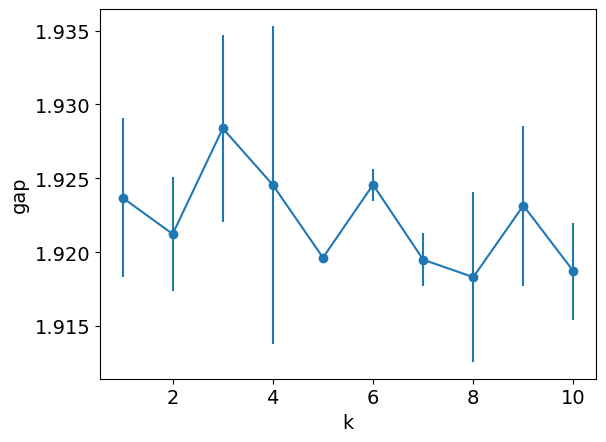

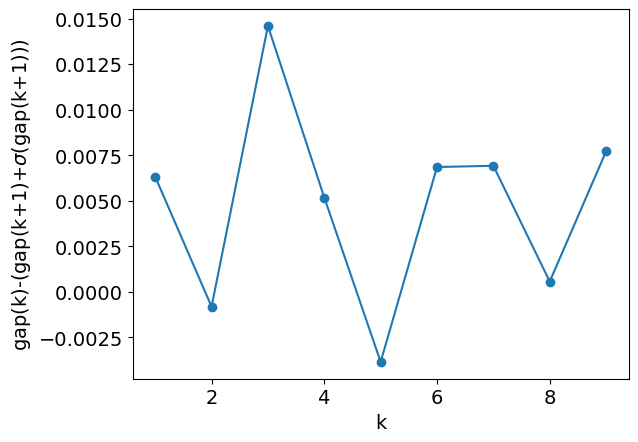

In [25]:
fig, ax = plt.subplots()
plt.errorbar(range(1, k_max+1), optimalK.gap_df['gap_value'], yerr=optimalK.gap_df['sk'], fmt='-o')
plt.ylabel('gap')
plt.xlabel('k')
plt.savefig("gap_new.svg",bbox_inches='tight')
plt.savefig("gap_new.pdf",bbox_inches='tight')
fig, ax = plt.subplots()
plt.plot(range(1, k_max+1), optimalK.gap_df['diff'], '-o')
plt.ylabel('gap(k)-(gap(k+1)+$\sigma$(gap(k+1)))')
plt.xlabel('k')
plt.savefig("diff.svg",bbox_inches='tight')
plt.savefig("diff.pdf",bbox_inches='tight')
# Get the best k which is the first k for which gap(k)-(gap(k+1)-sigma(k+1))>=0
bestK = -1;
for diffI in range(optimalK.gap_df['diff'].shape[0]):
    if optimalK.gap_df['diff'][diffI] > 0 and diffI+1 > 1:
        bestK = diffI+1;
        break;
print(bestK)

In [26]:
# Now get the cluster labels for the raw data
Kmean = KMeans(n_clusters=bestK, random_state=randomState)
#Kmean.fit(clusteringData)
Kmean.fit(clusteringData[trainBranches], sample_weight=rawDataPresel.clus_weight)
centroids = Kmean.cluster_centers_
clusLabels = Kmean.labels_

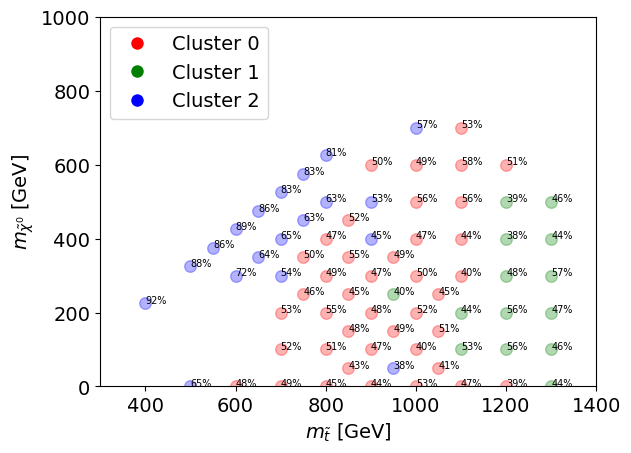

In [60]:
stopLSPMasses = {}
for sampLabel in goodSamps:
    dummy, stopMass, lspMass = sampLabel.split("_")[:3]
    stopMass = int(stopMass)
    lspMass = int(lspMass)
    stopLSPMasses[sampLabel] = (stopMass, lspMass)
    
stopMasses = []
lspMasses = []
# Clusters that contain the highest fraction of a signal are considered the best cluster.
bestClusters = {}
bestClusFracs = {}
for sampLabel in sorted(goodSamps):
    stopMass = stopLSPMasses[sampLabel][0]
    lspMass = stopLSPMasses[sampLabel][1]
    stopMasses.append(stopMass)
    lspMasses.append(lspMass)
    frac = -99
    bestClus = -1
    for clusI in range(bestK):
        sampIndex = (scaledData.sampName==sampLabel)
        sampClusIndex = (sampIndex) & (clusLabels==clusI)
        clusFrac = 1.*sum(sampClusIndex)/sum(sampIndex)
        if clusFrac > frac:
            frac = clusFrac
            bestClus = clusI
    bestClusters[(stopMass,lspMass)] = bestClus
    bestClusFracs[(stopMass, lspMass)] = frac
        
colors = ['r', 'g', 'b', 'y', 'c', 'k', 'm', 'tab:orange', 'tab:brown']
fig, ax = plt.subplots()
for stopLSPMass in bestClusters:
    plt.scatter(stopLSPMass[0], stopLSPMass[1], c=colors[bestClusters[stopLSPMass]], label=f'Cluster {bestClusters[stopLSPMass]}', alpha=0.3, s=70)
    ax.annotate(f'{round(bestClusFracs[stopLSPMass]*100)}%', stopLSPMass, fontsize=7)

ax.set_xlabel("$m_{\\tilde{t}}$ [GeV]")
ax.set_ylabel("$m_{\\tilde{\chi}^0}$ [GeV]")
ax.set_xlim(300,1400)
ax.set_ylim(0,1000)
handles, labels = plt.gca().get_legend_handles_labels()
sortedLabels = sorted(list(set(labels)))
legHandles = [matplotlib.lines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=colors[clusI], markersize=10) for clusI in range(bestK)]
plt.legend(ncol=1, handles=legHandles, labels=sortedLabels, loc='upper left')
plt.savefig(f"grid_postclustering_{varListStr}_gap.svg",bbox_inches='tight')
plt.savefig(f"grid_postclustering_{varListStr}_gap.pdf",bbox_inches='tight')
